# Feature Importance Based on SHAP Values

Based on the previous LazyPredict results, we selected the following models as the most promising candidates for further analysis:
* XGBRegressor	
* HistGradientBoostingRegressor	
* LGBMRegressor

In the next steps, we will tune these models using cross-validation on the preprocessed training data. Custom-developed tuners, tailored for different types of regressors, will be employed to optimize hyperparameters and improve model performance. Additionally, SHAP (SHapley Additive exPlanations) values will be utilized to assess feature importance and understand the contribution of individual features to the predictions.

In [ ]:
# Import requiered Libraries
import os
import pandas as pd
from tqdm import tqdm

# Import custom classes for hyper-parameter tunning
# NOTE: Below, PATH_TO_PROJECT is the location of the project folder (e.g: /home/sep24_bds_int_medical)
import sys
PATH_TO_SRC = 'PATH_TO_PROJECT/sep24_bds_int_medical'
sys.path.append( PATH_TO_SRC )

from src.features.tuners.XGBHyperparameterTuner import XGBHyperparameterTuner
from src.features.tuners.LGBMHyperparameterTuner import LGBMHyperparameterTuner
from src.features.tuners.HistGradientBoostingHyperparameterTuner import HistGradientBoostingHyperparameterTuner

# Import the preprocessign pipeline
from pipelines import *

# Disable warnings
import warnings
warnings.filterwarnings("ignore") 

# Import metrics for scoring
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, root_mean_squared_error
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# Libraries for Plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Read and display the train.csv and test.csv data
data_dir = '../../../../data/'
train_file = os.path.join( data_dir , 'raw' , 'train.csv' )
test_file = os.path.join( data_dir , 'raw' , 'train.csv' )

df_train = pd.read_csv(train_file, index_col = 0 , parse_dates = True )
df_test = pd.read_csv(test_file, index_col = 0 , parse_dates = True )

## Data Preprocessing

### Main steps
* Re-encoding the ``timestamp`` into a ``day-phase``
* Dropping the following columns: ``activity``, ``carbs``, ``steps`` , ``p_num``and ``time``
* Imputing NANs in the remaining columns with interpolation and medians
* Two negative values in  the ``insulin`` column replaced with ``0``
* The column ``day-phase`` is re-encoded using ``pd.get_dummies()``
* Finally, all columns were transformed using ``StandardScaler``.

In [3]:
# Split the data into Features and Target variables, 
# and Standarize the features with the preprocessing pipelines
X = df_train.drop( 'bg+1:00' , axis = 1 )
y = df_train['bg+1:00']

data_pipe = pipeline
Xs = data_pipe.fit_transform( X )
Xs_test = data_pipe.transform( df_test )

# fix column names - Needed for LGBM
import re
Xs.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in Xs.columns]
Xs_test.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in Xs_test.columns]

# Display descriptive statistics
display( Xs.describe() )
display( Xs_test.describe() )

,bg_5_55,bg_5_50,bg_5_45,bg_5_40,bg_5_35,bg_5_30,bg_5_25,bg_5_20,bg_5_15,bg_5_10,...,cals_0_20,cals_0_15,cals_0_10,cals_0_05,cals_0_00,day_phase_evening,day_phase_late_evening,day_phase_morning,day_phase_night,day_phase_noon
count,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,...,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05
mean,6.678999e-17,7.128547e-16,1.746815e-16,-1.066071e-16,-8.862518e-17,-2.568846e-18,-2.851419e-16,7.231301e-16,-2.414715e-16,2.825730e-17,...,1.592684e-16,1.644061e-16,4.623922e-17,-1.541307e-17,2.260584e-16,-3.901434e-17,-1.461031e-17,-1.031552e-17,-7.385432e-18,-1.590276e-16
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,...,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-2.022989e+00,-2.023072e+00,-2.024274e+00,-2.025959e+00,-2.025008e+00,-2.024706e+00,-2.026471e+00,-2.025571e+00,-2.025234e+00,-2.027086e+00,...,-1.132252e+00,-1.131288e+00,-1.131634e+00,-1.132097e+00,-1.134014e+00,-4.444915e-01,-2.978734e-01,-4.491221e-01,-5.752456e-01,-4.505926e-01
25%,-7.257353e-01,-7.256400e-01,-7.259481e-01,-7.264489e-01,-7.260141e-01,-7.258175e-01,-7.263474e-01,-7.259236e-01,-7.257157e-01,-7.262965e-01,...,-3.878293e-01,-3.873843e-01,-3.875796e-01,-3.875481e-01,-3.873682e-01,-4.444915e-01,-2.978734e-01,-4.491221e-01,-5.752456e-01,-4.505926e-01
50%,-1.935287e-01,-1.933603e-01,-1.933016e-01,-1.933167e-01,-1.930933e-01,-1.929402e-01,-1.929632e-01,-1.927349e-01,-1.925801e-01,-1.926393e-01,...,-3.103131e-01,-3.099221e-01,-3.101018e-01,-3.100189e-01,-3.096205e-01,-4.444915e-01,-2.978734e-01,-4.491221e-01,-5.752456e-01,-4.505926e-01
75%,5.382552e-01,5.385243e-01,5.390874e-01,5.397402e-01,5.396728e-01,5.397660e-01,5.404402e-01,5.403995e-01,5.404813e-01,5.411395e-01,...,-1.031577e-01,-1.042468e-01,-1.043850e-01,-1.028285e-01,-1.045274e-01,-4.444915e-01,-2.978734e-01,-4.491221e-01,-5.752456e-01,-4.505926e-01
max,6.492316e+00,6.493403e+00,6.498071e+00,6.504157e+00,6.501724e+00,6.501330e+00,6.507676e+00,6.505448e+00,6.504936e+00,6.511430e+00,...,1.438034e+01,1.437049e+01,1.437327e+01,1.438312e+01,1.442491e+01,2.249762e+00,3.357131e+00,2.226566e+00,1.738388e+00,2.219300e+00


,bg_5_55,bg_5_50,bg_5_45,bg_5_40,bg_5_35,bg_5_30,bg_5_25,bg_5_20,bg_5_15,bg_5_10,...,cals_0_20,cals_0_15,cals_0_10,cals_0_05,cals_0_00,day_phase_evening,day_phase_late_evening,day_phase_morning,day_phase_night,day_phase_noon
count,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,...,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000
mean,0.184348,0.186197,0.186528,0.184169,0.180827,0.178788,0.180075,0.179307,0.178202,0.179529,...,-0.166944,-0.160694,-0.159051,-0.163727,-0.169704,0.020570,-0.006998,-0.021041,0.015226,0.016126
std,1.115628,1.113388,1.111815,1.107850,1.104784,1.100944,1.095559,1.092830,1.090529,1.088190,...,0.891142,0.891972,0.910754,0.911728,0.933371,1.018330,0.989349,0.981031,1.008840,1.014172
min,-1.823411,-2.023072,-1.891112,-2.025959,-1.958393,-1.924791,-1.837565,-1.858949,-1.891950,-2.027086,...,-1.133589,-1.132624,-1.132969,-1.133433,-1.135355,-0.444492,-0.297873,-0.449122,-0.575246,-0.450593
25%,-0.625947,-0.592570,-0.592786,-0.593166,-0.603886,-0.592598,-0.593001,-0.592626,-0.592432,-0.592882,...,-0.534843,-0.534295,-0.534520,-0.534586,-0.537837,-0.444492,-0.297873,-0.449122,-0.575246,-0.450593
50%,-0.060477,-0.060290,-0.060140,-0.060034,-0.093171,-0.065272,-0.059617,-0.059438,-0.059296,-0.048107,...,-0.403867,-0.382376,-0.397598,-0.413614,-0.423561,-0.444492,-0.297873,-0.449122,-0.575246,-0.450593
75%,0.804358,0.771397,0.774894,0.750772,0.750621,0.739595,0.740459,0.740345,0.740407,0.766276,...,-0.234133,-0.226784,-0.233960,-0.215112,-0.233213,-0.444492,-0.297873,-0.449122,1.738388,-0.450593
max,6.425790,6.426868,6.431490,6.293126,6.312981,6.334806,6.396555,6.449907,6.504936,6.511430,...,7.689893,7.684706,7.214594,9.294255,9.190347,2.249762,3.357131,2.226566,1.738388,2.219300


## Model Tuning

The code below initializes three hyperparameter tuners for XGBoost, LightGBM, and Histogram-based Gradient Boosting, fits them to the dataset to optimize their parameters. It reuses then saved tuners as pickle files, extracts the best models for each algorithm, and evaluates their performance using root mean squared error (RMSE) on the training dataset. Finally, we organize the RMSE results in a DataFrame and sort them to rank the models.

In [4]:
# Instantiate and fit the Tunners
# xgb_tuner = XGBHyperparameterTuner( search_space = 'default' )
# lgbm_tuner = LGBMHyperparameterTuner( search_space = 'default' )
# hist_tuner = HistGradientBoostingHyperparameterTuner( search_space = 'default' )

# xgb_tuner.fit(X=Xs, y=y)
# lgbm_tuner.fit(X=Xs, y=y)
# hist_tuner.fit(X=Xs, y=y)

In [5]:
# Fit the Tuners 
# xgb_tuner.fit(X=Xs, y=y)
# lgbm_tuner.fit(X=Xs, y=y)
# hist_tuner.fit(X=Xs, y=y)
# lasso_tuner.fit(X=Xs, y=y)
# ridge_tuner.fit(X=Xs, y=y) 
# knn_tuner.fit(X=Xs, y=y)
# dummy_reg.fit(X=Xs, y=y)


In [6]:
# Save or Read results from hyper-parameter tunning
def save_pickle( obj , file_name ):
    
    import pickle
    # Save to pickle file
    file_path = f'./models/bayes_search_res/{file_name}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump(obj, f)

    f.close()

def read_pickle( file_name ):
    import pickle

    # Specify the path to your pickle file
    file_path = f'./models/bayes_search_res/{file_name}.pkl'
    
    # Open the pickle file in binary read mode and load the object
    with open(file_path, 'rb') as f:
        obj = pickle.load( f )

    f.close()

    return obj

# Save results
# save_pickle( xgb_tuner , 'xgb_tuner_res' )
# save_pickle( lgbm_tuner , 'lgbm_tuner_res' )
# save_pickle( hist_tuner , 'hist_tuner_res' )

# Read Results
xgb_tuner = read_pickle( 'xgb_tuner_res' )
lgbm_tuner= read_pickle( 'lgbm_tuner_res' )
hist_tuner = read_pickle( 'hist_tuner_res' )


In [7]:
# Extract Best Models
xgb_best_model = xgb_tuner.get_best_model()
lgbm_best_model = lgbm_tuner.get_best_model()
hist_best_model = hist_tuner.get_best_model()

# Print the CV RMSE for the best models
xgb_rmse = root_mean_squared_error( y_true = y , y_pred = xgb_best_model.predict( X = Xs ) )
lgmb_rmse = root_mean_squared_error( y_true = y , y_pred = lgbm_best_model.predict( X = Xs ) )
hist_rmse = root_mean_squared_error( y_true = y , y_pred = hist_best_model.predict( X = Xs ) )

rmse_df = pd.DataFrame({
    'model':['xgb','lgbm','hist'],
    'rmse':[xgb_rmse,lgmb_rmse,hist_rmse]
})

rmse_df.sort_values( 'rmse' , inplace = True )
rmse_df

,model,rmse
1,lgbm,1.757358
0,xgb,1.880405
2,hist,1.932709


## Model Evaluation: Real vs. Predicted Correlation & Residuals Distribution
For each of the selected models, we evaluate their performance by analyzing the correlation between real and predicted values and the distribution of residuals. 
The plots below represent following insights:
* Real vs. Predicted Correlation: Shows how well the model's predictions align with the actual target values.
* Residuals Distribution: Indicates how errors are distributed, providing insight into bias and variance.

The following sections summarize these evaluations.
### 1. XGBoost Model

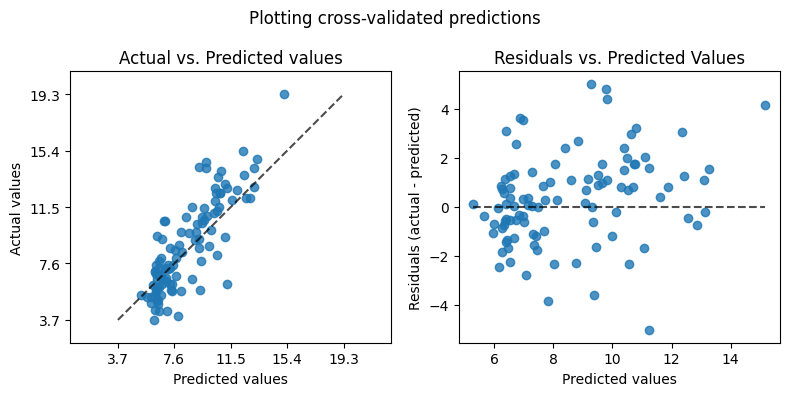

In [8]:
xgb_tuner.show_chart()

### 2. LGBM Model

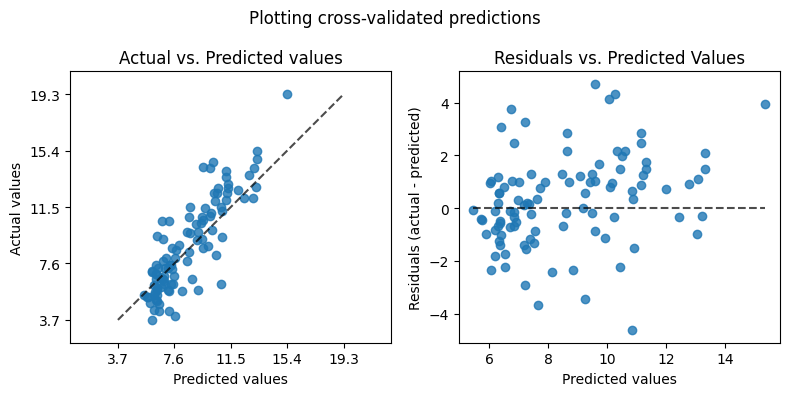

In [9]:
lgbm_tuner.show_chart()

### 3. HistGradientBoosting Model

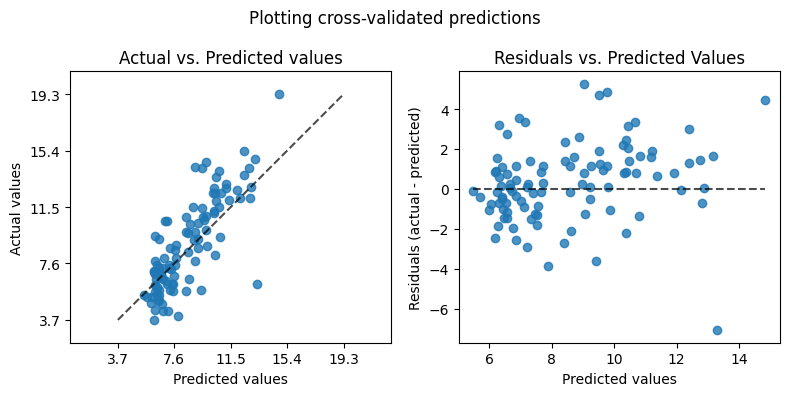

In [10]:
hist_tuner.show_chart()

**Conclusion:** All three models perform comparably well. The points in the correlation charts align reasonably well along the diagonal, indicating a strong correlation between actual and predicted values. However, some spread is observed, especially at higher values, indicating some underperformance in those areas. 
Looking at the residuals distributions, we can conclude that residuals are generally centered around zero, but show moderate dispersion, with occasional outliers. The LGBM model shows slightly more variability in residuals, while the HistGradientBoosting model shows greater dispersion and clustering, suggesting it may struggle to generalize in specific ranges. 

## Cross-Validated RMSE Scores for Top 100 Features
This section details the process of calculating cross-validated RMSE scores for Train/Test splits using the top 100 features identified through SHAP importance.

1. The function ``train_test_cv`` calculates RMSE scores for a model by iteratively evaluating its performance on subsets of the top 100 SHAP-ranked features.
2. Features are sorted by importance using the SHAP framework.
3. A 5-fold cross-validation is performed for each subset of features (from 1 to 100). Both train and test RMSE scores are calculated.
4. Train and test RMSE scores for each subset are stored in a results dataframe for comparison.
5. A dataframe containing RMSE scores for each feature subset, split by the model type.

In [11]:
def train_test_cv( tuner_res , name_tag):

    from src.features.helpers.ShapWrapper import ShapWrapper

    print(f'Calculating scores for {name_tag}')

    model = tuner_res.get_best_model()
    shap = ShapWrapper( model = model , X = Xs )
    sorted_list = shap.get_top_features()

    train_rmse_vals = []
    test_rmse_vals = []

    for n in tqdm( range(1,101) ):
        # Perform cross-validation, specifying both train and test scores
        cv_results = cross_validate(
            model, Xs[ sorted_list[:n] ], y, cv=5,
            scoring = rmse_scorer , 
            return_train_score=True
        )

        # Extract train and test scores
        train_scores = cv_results['train_score']
        test_scores = cv_results['test_score']

        # Display the results
        # Append final scores
        train_rmse_vals.append( -1*train_scores.mean() )
        test_rmse_vals.append( -1*test_scores.mean() )

        #Create a results df
        res = pd.DataFrame({
            'model':name_tag,
            'train_rmse':train_rmse_vals,
            'test_rmse':test_rmse_vals
        })

    return res


In [12]:
# Load base regressorsors

# xgb_rmse_vals = train_test_cv( xgb_tuner , 'XGBRegressor' )
# lgbm_rmse_vals = train_test_cv( lgbm_tuner , 'LGBMRegressor' )
# hist_rmse_vals = train_test_cv( hist_tuner , 'HistGradientBoostingRegressor' )

# rmse_vals_df = pd.concat([ 
#     xgb_rmse_vals.reset_index() , 
#     lgbm_rmse_vals.reset_index() , 
#     hist_rmse_vals.reset_index() 
# ])

# rmse_vals_df.to_csv( './models/results_tables/01_RMSE_at different_topN_features.csv' , index=False )

#Read the global results table
rmse_vals_df = pd.read_csv( './models/results_tables/01_RMSE_at different_topN_features.csv'  )
df_melt = rmse_vals_df.melt( id_vars=['index','model'] , var_name='type' , value_name='rmse' )
df_melt.head()

,index,model,type,rmse
0,0,XGBRegressor,train_rmse,2.122145
1,1,XGBRegressor,train_rmse,2.145826
2,2,XGBRegressor,train_rmse,2.037226
3,3,XGBRegressor,train_rmse,2.030764
4,4,XGBRegressor,train_rmse,2.004605


## Plotting Model Performance Based on Top N Features

### 1. Performance for Top 100 Features
Using the RMSE scores for increasing numbers of SHAP-important features, the performance of each model is visualized to understand how adding more features affects model accuracy.

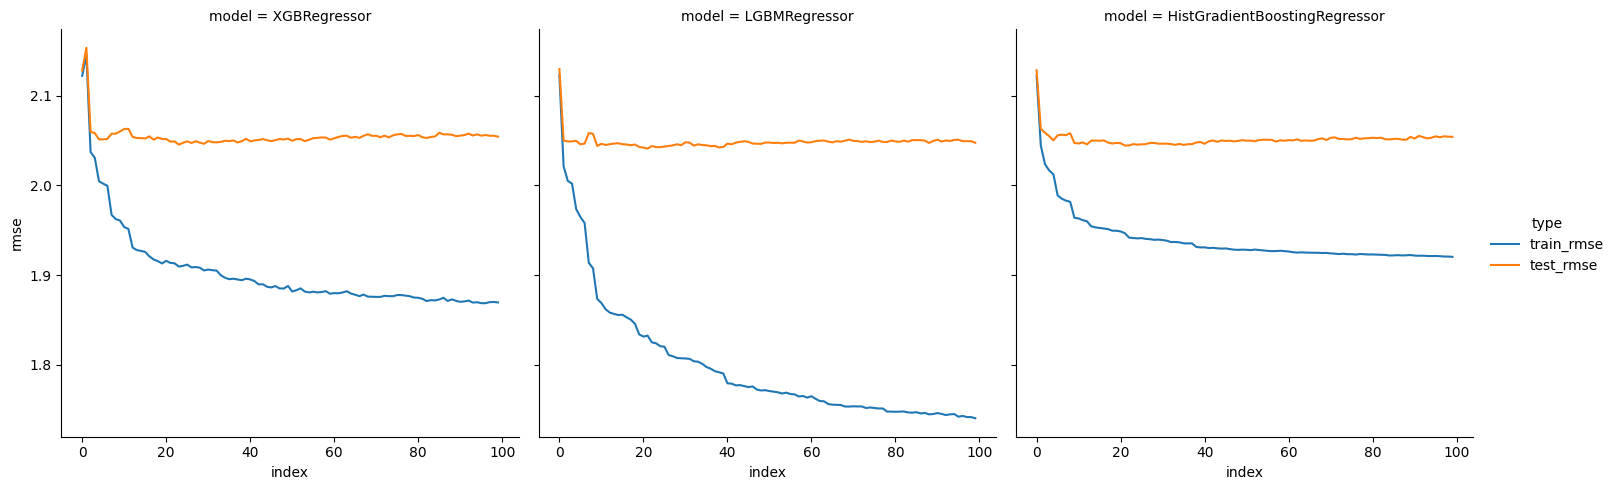

In [13]:
sns.relplot(
    data = df_melt , 
    x = 'index' , 
    y = 'rmse' , 
    hue = 'type' ,
    kind = 'line',
    col= 'model'
)

### 2. Performance for Top 10 Features
A refined view of the performance is created by restricting the dataset to only the top 10 SHAP-important features.

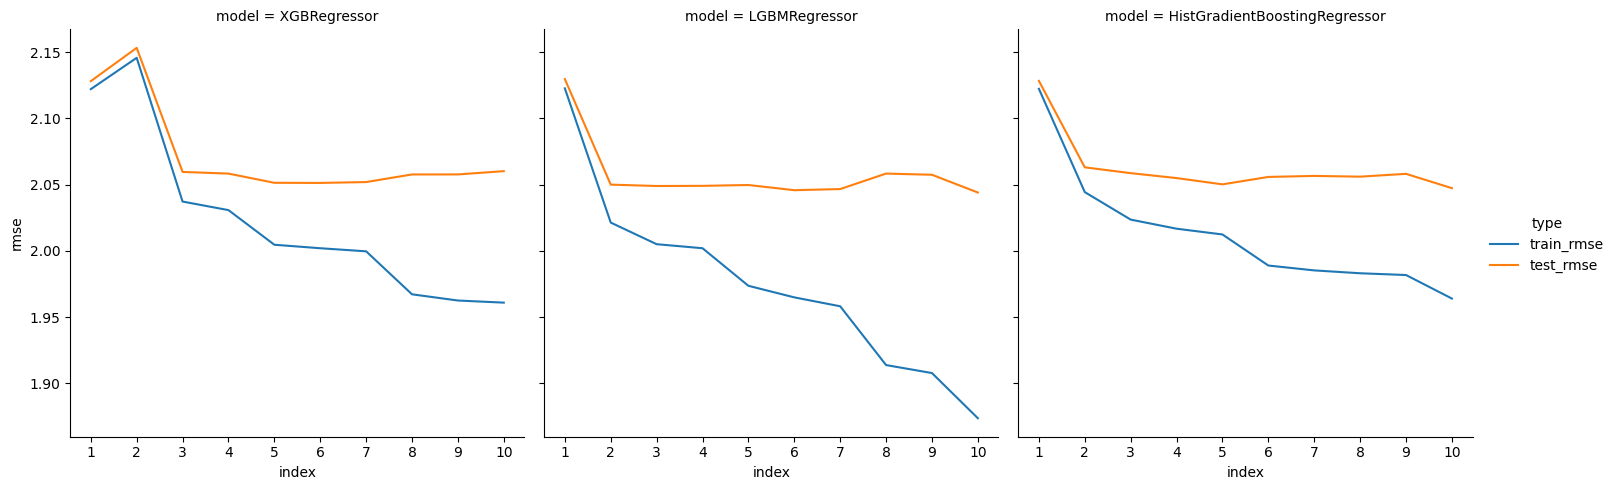

In [14]:
g = sns.relplot(
    data = df_melt[ df_melt['index'] <= 9 ] , 
    x = 'index' , 
    y = 'rmse' , 
    hue = 'type' ,
    kind = 'line',
    col= 'model'
)

plt.xticks(
    ticks = list( range(10) ) , 
    labels = [x+1 for x in list( range(10) )]
    );


### Observations:
* Top 100 features:
    * RMSE (blue) decreases significantly as more features are added, particularly within the first ~20-30 features.
    * Test RMSE (orange) also decreases with the addition of features but flatten after approximately 20-30 features, indicating that additional features provide little to no improvement in generalization performance.
    * All three models exhibit similar trends, with XGBRegressor and LGBMRegressor slightly outperforming HistGradientBoostingRegressor in terms of RMSE.
* Top 10 features:
    * Beyond 6-7 features, the train RMSE stabilizes, showing minimal benefit from additional features in this range.
    * Test RMSE shows a similar sharp decline with the first few features but stabilizes quickly, suggesting that only the top features have significant generalization power.
    * XGBRegressor appears to maintain slightly lower RMSE compared to LGBM and HistGradientBoosting, but the differences are minor.

## Extracting the Top 10 Most Important Features
This code extracts the top 10 features for each model based on feature importance and identifies the common features across all three models.

In [15]:
def print_top_features( tuner , tag , n = 10 ):
    dfs = tuner.get_feature_importance()
    res_l = dfs['feature'][:n].tolist()
    print( f'Top_{n} { tag } fetures: \n{res_l}\n' )
    return res_l

xgboost_top_features = print_top_features( xgb_tuner , 'XGBoost' )
lgbm_top_features = print_top_features( lgbm_tuner , 'LGBM' )
hist_top_features =print_top_features( hist_tuner , 'HistGradientBoosting' )

common_top_feats = set(xgboost_top_features) & set(lgbm_top_features) & set(hist_top_features)
common_top_feats = list(common_top_feats)
print( f'Common Top fetures: \n{common_top_feats}\n' )

Top_10 XGBoost fetures: 
['bg_0_00', 'bg_0_05', 'bg_0_10', 'bg_0_15', 'hr_0_00', 'day_phase_night', 'bg_0_20', 'insulin_0_00', 'day_phase_evening', 'hr_0_05']

Top_10 LGBM fetures: 
['bg_0_00', 'bg_0_05', 'bg_0_15', 'bg_0_10', 'hr_0_00', 'day_phase_night', 'day_phase_evening', 'insulin_0_00', 'hr_0_05', 'cals_0_00']

Top_10 HistGradientBoosting fetures: 
['bg_0_00', 'bg_0_15', 'hr_0_00', 'day_phase_night', 'bg_0_10', 'insulin_0_00', 'insulin_0_10', 'day_phase_evening', 'bg_0_20', 'cals_0_00']

Common Top fetures: 
['hr_0_00', 'bg_0_15', 'day_phase_evening', 'bg_0_00', 'insulin_0_00', 'day_phase_night', 'bg_0_10']



## Beeswarm Plots of SHAP Values for Common Most-Important Features

The SHAP beeswarm plots display the impact of each feature on the model's predictions, highlighting how feature values contribute positively or negatively to the predicted outcomes. Using the common top features ensures a consistent comparison across models.

In [16]:
import shap

xgb_explainer = shap.Explainer( xgb_best_model  )
lgbm_explainer = shap.Explainer( lgbm_best_model )
hist_explainer = shap.Explainer( hist_best_model )

xgb_shap_values = xgb_explainer( Xs )
lgbm_shap_values = lgbm_explainer( Xs )
hist_shap_values = hist_explainer( Xs )

### 1. XGBoost Model - SHAP Values

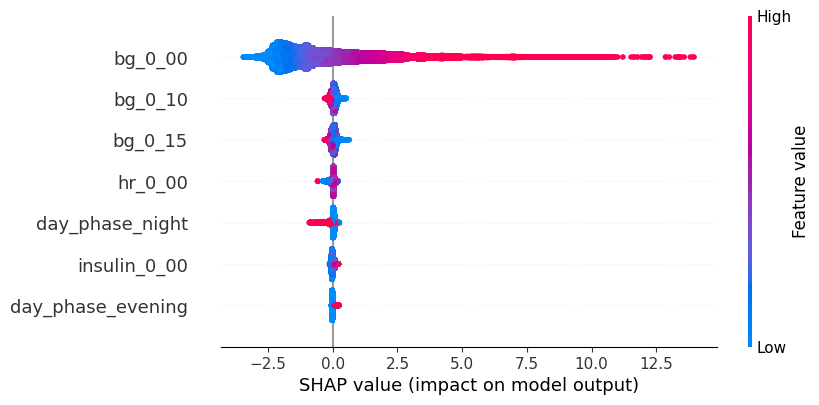

In [17]:
shap.plots.beeswarm( xgb_shap_values[:,common_top_feats] , max_display = len( xgb_shap_values ) )

### 2. LGBM Model - SHAP Values

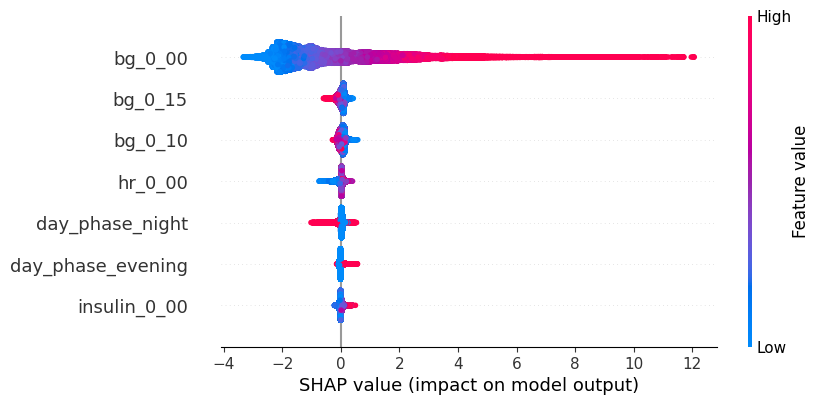

In [18]:
shap.plots.beeswarm( lgbm_shap_values[:,common_top_feats] )

### 3. HistGradientBoosting Model - SHAP Values

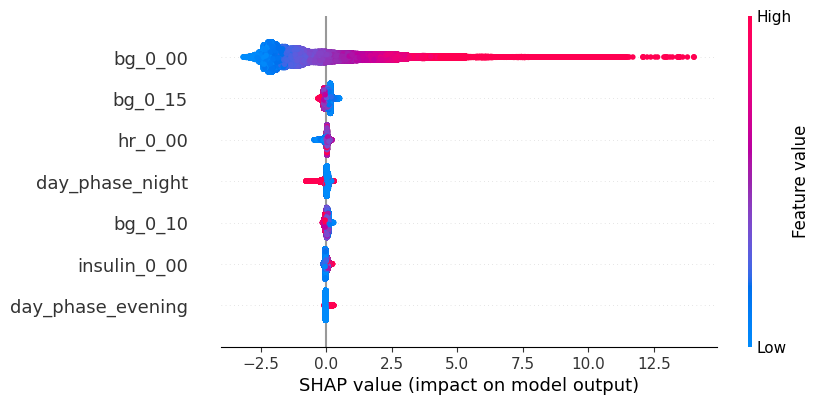

In [19]:
shap.plots.beeswarm( hist_shap_values[:,common_top_feats] )

### Observations:
* Lagged glucose features ``bg_0_00``, ``bg_0_10``, ``bg_0_15`` are consistently the most impactful predictors.
* ``day_phase`` features (``day_phase_night``, ``day_phase_evening``) and ``hr_0_00`` show less impactful, but still significant contributions across models.
* `insulin_0_00` also consistently contributes to predictions but with moderate SHAP impact.

### Summary
* Based on RMSE scores, correlation plots, and residual analyses, all three tested models (**XGBoost**, **LGBM**, and **HistGradientBoosting**) perform reasonably well.
* The best performance after hyperparameter tunning can be achieved using the **Top 10 most important features** identified through SHAP values.
* For all the three tree-based models tested, **bg-0:00** (the most recent blood glucose reading) prominently emerges as the most important feature in predicting future glucose levels.
